<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: calwebb_image3: source_catalog with MIRI

<span style="color:red"> **Instruments Affected**</span>: MIRI, NIRCam 


Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Run Pipeline](#pipeline_ID) <br> [Check Results](#output_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>

## Introduction

This notebook processes a set of images through calwebb_image2 and calwebb_image3 and examines the output table of the source_catalog step. 

This test uses simulated MIRI F770W (options for F560W or F770W) data of a crowded star + galaxy field.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/main.html

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst



### JWST Calibration working group algorithm

The algorithm and discussion for this step can be found at the following page:

https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Point+Source+Catalog

### Test description

The steps of this test are as follow:

1) Set up data path and directory and image files name.

2) Run output of calwebb_detector1 through calwebb_image2.

3) Run output of calwebb_image2 through calwebb_image3. 

4) Read in output table of source_catalog step and print ecsv table 

5) Display image and overplot detector sources from ecsv table. 

6) Look at plots of total flux in Jy and AB mag.

7) Look for matches between expected source positions (RA and Dec) from simulated catalog to output from source_catalog.

8) Compare magnitudes and magnitude differences between input simulated catalog and output found sources.

### Data description

The data used in this test consist of a set of four simulated images in the F770W filter of MIRI, at four different dither positions. The data have 4827 stars of varying flux levels and just over 200 galaxies in the image. The MIRI Image simulator (MIRISim) was used to create the simulations.

### Create a temporary directory for all of the test data

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

# For info, print out where the script is running
print("Running in {}".format(os.getcwd()))

Running in /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports_ID"></a>
### Set up import statements

The following packages are needed to enable this notebook to run:
* astropy for coordinate handling and calculations
* jwst to run the pipeline steps and create associations
* matplotlib for plotting
* ci_watson for retrieving data from artifactory
* set of tools to retrieve data from Box

[Top of Page](#title_ID)

In [3]:
#import pytest
import numpy as np
from glob import glob
import json
import matplotlib.pyplot as plt
import photutils

from astropy.io import fits, ascii
from astropy.coordinates import Angle
from astropy.table import Table, vstack, unique, join
from astropy import table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import simple_norm
from astropy import units as u
from astropy.modeling import models
from astropy.wcs import WCS

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

import jwst
from jwst import datamodels
from jwst.datamodels import RampModel, ImageModel

from jwst import associations
from jwst.associations import asn_from_list
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base

from jwst.pipeline import calwebb_image3
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline

from ci_watson.artifactory_helpers import get_bigdata


### Put in some helper scripts


In [4]:
def create_scatterplot(catalog_colx, catalog_coly, title=None):
    ''' Function to generate a generic scatterplot.
    '''
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    ax.scatter(catalog_colx,catalog_coly) 
    plt.xlabel(catalog_colx.name)
    plt.ylabel(catalog_coly.name)

    
    if title:
        plt.title(title)

In [5]:
# Band info from constants in miricap

# wref in microns and zeropoint in Jy
band_info = {
    "2MASS J": {'wref': 1.235, 'zeropoint': 1594},
    "2MASS H": {'wref': 1.662, 'zeropoint': 1024},
    "2MASS Ks": {'wref': 2.159, 'zeropoint': 666.7},
    "Johnson U": {'wref': 0.36, 'zeropoint': 1823},
    "Johnson B": {'wref': 0.44, 'zeropoint': 4130},
    "Johnson V": {'wref': 0.55, 'zeropoint': 3781},
    "Johnson R": {'wref': 0.71, 'zeropoint': 2941},
    "Johnson I": {'wref': 0.97, 'zeropoint': 2635},
    "Johnson J": {'wref': 1.25, 'zeropoint': 1603},
    "Johnson H": {'wref': 1.60, 'zeropoint': 1075},
    "Johnson K": {'wref': 2.22, 'zeropoint': 667},
    "Johnson L": {'wref': 3.54, 'zeropoint': 288},
    "Johnson M": {'wref': 4.80, 'zeropoint': 170},
    "Johnson N": {'wref': 10.6, 'zeropoint': 36},
    "Johnson O": {'wref': 21.0, 'zeropoint': 9.4},
    "UKIRT V": {'wref': 0.5556, 'zeropoint': 3540},
    "UKIRT I": {'wref': 0.9, 'zeropoint': 2250},
    "UKIRT J": {'wref': 1.25, 'zeropoint': 1600},
    "UKIRT H": {'wref': 1.65, 'zeropoint': 1020},
    "UKIRT K": {'wref': 2.20, 'zeropoint': 657},
    "UKIRT L": {'wref': 3.45, 'zeropoint': 290},
    "UKIRT L'": {'wref': 3.80, 'zeropoint': 252},
    "UKIRT M": {'wref': 4.8, 'zeropoint': 163},
    "UKIRT N": {'wref': 10.1, 'zeropoint': 39.8},
    "UKIRT Q": {'wref': 20.0, 'zeropoint': 10.4},
    "MIRLIN N": {'wref': 10.79, 'zeropoint': 33.4},
    "MIRLIN Q-s": {'wref': 17.90, 'zeropoint': 12.4},
    "MIRLIN N0": {'wref': 7.91, 'zeropoint': 60.9},
    "MIRLIN N1": {'wref': 8.81, 'zeropoint': 49.4},
    "MIRLIN N2": {'wref': 9.69, 'zeropoint': 41.1},
    "MIRLIN N3": {'wref': 10.27, 'zeropoint': 36.7},
    "MIRLIN N4": {'wref': 11.70, 'zeropoint': 28.5},
    "MIRLIN N5": {'wref': 12.49, 'zeropoint': 25.1},
    "MIRLIN Q0": {'wref': 17.20, 'zeropoint': 13.4},
    "MIRLIN Q1": {'wref': 17.93, 'zeropoint': 12.3},
    "MIRLIN Q2": {'wref': 18.64, 'zeropoint': 11.4},
    "MIRLIN Q3": {'wref': 20.81, 'zeropoint': 9.2},
    "MIRLIN Q4": {'wref': 22.81, 'zeropoint': 7.7},
    "MIRLIN Q5": {'wref': 24.48, 'zeropoint': 6.7},
    "MIRLIN K": {'wref': 2.2, 'zeropoint': 650.0},
    "MIRLIN M": {'wref': 4.68, 'zeropoint': 165.0},
    "WISE W1": {'wref': 3.4, 'zeropoint':309.54},
    "WISE W2": {'wref': 4.6, 'zeropoint':171.787},
    "WISE W3": {'wref': 12., 'zeropoint':31.674},
    "WISE W4": {'wref': 22., 'zeropoint':8.363},
}

In [6]:
# code from miricap.imager section written by Christophe Cossou of the MIRI EC team.

def get_band_info(band, system):
    """
    Retrieve information on a given band in a dictionnary 'band_info' that need to be
    available in global variable of the script at this level.
    :param str band: Band name (e.g. V for Johnson)
    :param str system: possible values: Johnson, 2MASS, UKIRT, MARLIN)
    :return: wref in microns and zeropoint in Jy
    :rtype: tuple(Quantity, Quantity)
    """

    system_list = ["Johnson", "2MASS", "UKIRT", "MARLIN"]

    if system not in system_list:
        LOG.info(f"Unknown system '{system}'. Possible values: {system_list}")
        return None, None

    key = f"{system} {band}"

    try:
        band_dict = band_info[key]
        zeropoint = band_dict["zeropoint"]
        wref = band_dict["wref"]
    except KeyError:
        bands = [k.split()[1] for k in band_info.keys() if system in k]
        LOG.info(f"Unknown band '{band}' for '{system}'. Available bands are: {', '.join(bands)}")
        return None, None

    return wref * u.micron, zeropoint * u.Jy



def mag2flux(magnitude, band, system="Johnson"):
    """
    Convert magnitude in a given band/system into flux in mJy (and return the corresponding wavelength reference
    :param float magnitude: magnitude in a given bandpass
    :param str band: band name (e.g 'V' or Johnson system)
    :param str system: (By default Johnson, possible values: Johnson, 2MASS, UKIRT, MARLIN)
    :return: flux in mJy and wref in microns
    :rtype: tuple(float, float)
    """

    wref, zero_point = get_band_info(band, system)

    flux = zero_point * 10.0 ** (-0.4 * magnitude)

    print(f"Magnitude {magnitude} in {system} band {band} -> Flux: {flux} at {wref} microns")

    return flux.to(u.mJy).value, wref.value


def extrapolate_flux(flux, wref, waves, temperature_star):
    """
    From a flux and reference wavelength, will return the flux for other wavelength
    (using the star effective temperature for the spectrum shape)
    To convert magnitude flux in a band, use one of the following website for instance:
    - http://ssc.spitzer.caltech.edu/warmmission/propkit/pet/magtojy/
    - https://www.gemini.edu/sciops/instruments/midir-resources/imaging-calibrations/fluxmagnitude-conversion
    :param float flux: Star flux in mJy
    :param float wref: reference wavelength (microns) corresponding to the flux given in parameter
    :param waves: list of wavelengths you want to extrapolate the star flux on.
    :type waves: float or list(float) or np.array(float)
    :param float temperature_star: star effective temperature in K
    :return: flux values for all required wavelengths. Unit will be the unit of the input flux
    :rtype: quantity or np.array(quantity)
    """
    flux = flux * u.mJy
    wref = wref * u.micron
    waves = waves * u.micron

    bb_star = models.BlackBody(temperature_star * u.K)

    extrapolated_flux = flux * bb_star(waves) / bb_star(wref)

    print(f"Assuming T={temperature_star} K, Flux: {flux} at {wref} -> Flux: {extrapolated_flux} at {waves}")

    return extrapolated_flux

### Print pipeline version number

In [7]:
print(jwst.__version__) 
print(data_dir)

1.3.2
<TemporaryDirectory '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d'>


### Read in data from artifactory

In [8]:
# Read in new dataset from Box

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

# Use F560W data set
        
#file_urls = ['https://stsci.box.com/shared/static/g8ozd2wkdo9klrtkafpe9qegpzhpd66a.fits', 
#             'https://stsci.box.com/shared/static/ym75nbqdi32t9wnbanm6s57itqixniyc.fits', 
#             'https://stsci.box.com/shared/static/0bqh6ijsc6kd7cyv6gtnj9kvly9t885f.fits',
#             'https://stsci.box.com/shared/static/tywadpqcjhp9yxyv0sy91hc79red92xm.fits',
#             'https://stsci.box.com/shared/static/lpcgp7jkq6lmjj2lxpk63jz9u05qgk3a.cat',
#             'https://stsci.box.com/shared/static/15j6hkjc28zow4rjepob2t75dl887zs3.cat']

#file_names = ['det_image_seq1_MIRIMAGE_F560Wexp1_rate.fits', 
#             'det_image_seq2_MIRIMAGE_F560Wexp1_rate.fits', 
#             'det_image_seq3_MIRIMAGE_F560Wexp1_rate.fits',
#             'det_image_seq4_MIRIMAGE_F560Wexp1_rate.fits',
#             'input_sim_stars.cat',
#             'input_sim_galaxies.cat']

# Test with F770W data set

file_urls = ['https://stsci.box.com/shared/static/8573htf1p8mhk4e49z9b483dp975y3lz.fits',
             'https://stsci.box.com/shared/static/p69h7uzlmqwlzf6kqqbf4lu9ibz28tc6.fits',
             'https://stsci.box.com/shared/static/js8k6j20rek1oago057wxn08dhuticij.fits',
             'https://stsci.box.com/shared/static/es253mc3m1sptusj9c9ctl1blidr1qdl.fits',
             'https://stsci.box.com/shared/static/lpcgp7jkq6lmjj2lxpk63jz9u05qgk3a.cat',
             'https://stsci.box.com/shared/static/15j6hkjc28zow4rjepob2t75dl887zs3.cat']


file_names = ['det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits', 
             'det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits', 
             'det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits',
             'det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits',
             'input_sim_stars.cat',
             'input_sim_galaxies.cat']


box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]


get_box_files(box_download_list)


<a id="pipeline_ID"></a>
## Run Pipelines

Read in the data and run the JWST calibration pipelines.


### Run output of calwebb_detector1 through calwebb_image2

In [9]:
# Run Calwebb_image2 on output files from detector1
ratefiles = glob('*rate.fits')    
    
print('There are ', len(ratefiles), ' images.')
    
callist = []

# cycle through files
for im in ratefiles:
    pipe2 = Image2Pipeline()
    
    rampfile = ImageModel(im)
    filename = rampfile.meta.filename
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)

2022-01-28 12:55:45,614 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-28 12:55:45,616 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-28 12:55:45,618 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-28 12:55:45,620 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-28 12:55:45,622 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-28 12:55:45,623 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


There are  4  images.


2022-01-28 12:55:46,581 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:46,587 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d/det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'outp

2022-01-28 12:55:46,596 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-28 12:55:46,858 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-01-28 12:55:46,862 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-28 12:55:46,863 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-28 12:55:46,864 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-28 12:55:46,865 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-28 12:55:46,867 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-01-28 12:55:46,870 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-01-28 12:55:46,872 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-28 12:55:46,872 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-01-28 12:55:46,875 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0729.fits'.


2022-01-28 12:55:46,877 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-28 12:55:46,878 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-28 12:55:46,878 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-28 12:55:46,880 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-28 12:55:46,881 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-28 12:55:46,881 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-28 12:55:46,882 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-28 12:55:46,883 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-01-28 12:55:46,885 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-28 12:55:46,886 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-28 12:55:46,886 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-28 12:55:46,887 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-28 12:55:46,888 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-28 12:55:46,888 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-28 12:55:46,951 - stpipe.Image2Pipeline - INFO - Processing product det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:55:46,953 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits> ...


2022-01-28 12:55:47,120 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:47,123 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 12:55:47,419 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 12:55:47,499 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410454 -0.016139226 0.021877929 0.015048364 359.990819065 0.017621109 359.988011818 -0.013580304


2022-01-28 12:55:47,500 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410454 -0.016139226 0.021877929 0.015048364 359.990819065 0.017621109 359.988011818 -0.013580304


2022-01-28 12:55:47,501 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-28 12:55:47,541 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-01-28 12:55:47,606 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-28 12:55:47,742 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:47,744 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-28 12:55:47,874 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:47,875 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:47,876 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:47,884 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:48,021 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-28 12:55:48,138 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:48,140 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-01-28 12:55:48,166 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-01-28 12:55:48,167 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-01-28 12:55:48,246 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-01-28 12:55:48,247 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-01-28 12:55:48,248 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-01-28 12:55:48,248 - stpipe.Image2Pipeline.photom - INFO -  filter: F770W


2022-01-28 12:55:48,305 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-01-28 12:55:48,308 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-01-28 12:55:48,309 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788


2022-01-28 12:55:48,328 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-28 12:55:48,447 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:48,449 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-28 12:55:48,476 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-01-28 12:55:48,606 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-01-28 12:55:49,304 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:49,667 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-01-28 12:55:50,328 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:50,695 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-01-28 12:55:51,384 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:51,790 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-01-28 12:55:52,428 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:52,822 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358561 -0.016335069 0.022108776 0.015004270 359.990738771 0.017757176 359.987988557 -0.013582163


2022-01-28 12:55:52,952 - stpipe.Image2Pipeline.resample - INFO - Saved model in det_image_seq1_MIRIMAGE_F770Wexp1_i2d.fits


2022-01-28 12:55:52,953 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-01-28 12:55:52,954 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq1_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:55:52,956 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-28 12:55:53,134 - stpipe.Image2Pipeline - INFO - Saved model in det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits


2022-01-28 12:55:53,135 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-28 12:55:53,144 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-28 12:55:53,146 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-28 12:55:53,148 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-28 12:55:53,150 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-28 12:55:53,152 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-28 12:55:53,154 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-28 12:55:53,388 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:53,394 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d/det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'outp

2022-01-28 12:55:53,402 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-28 12:55:53,406 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-01-28 12:55:53,409 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-28 12:55:53,410 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-28 12:55:53,412 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-28 12:55:53,413 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-28 12:55:53,414 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-01-28 12:55:53,416 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-01-28 12:55:53,418 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-28 12:55:53,419 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-01-28 12:55:53,421 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0729.fits'.


2022-01-28 12:55:53,424 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-28 12:55:53,424 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-28 12:55:53,425 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-28 12:55:53,426 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-28 12:55:53,426 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-28 12:55:53,427 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-28 12:55:53,428 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-28 12:55:53,428 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-01-28 12:55:53,430 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-28 12:55:53,431 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-28 12:55:53,432 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-28 12:55:53,433 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-28 12:55:53,433 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-28 12:55:53,434 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-28 12:55:53,490 - stpipe.Image2Pipeline - INFO - Processing product det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:55:53,491 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits> ...


2022-01-28 12:55:53,681 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:53,684 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 12:55:53,869 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 12:55:53,938 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049595 -0.017461020 0.022517071 0.013726570 359.991458207 0.016299315 359.988650959 -0.014902098


2022-01-28 12:55:53,939 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049595 -0.017461020 0.022517071 0.013726570 359.991458207 0.016299315 359.988650959 -0.014902098


2022-01-28 12:55:53,940 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-28 12:55:53,978 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-01-28 12:55:54,036 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-28 12:55:54,220 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:54,222 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-28 12:55:54,344 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:54,346 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:54,347 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:54,355 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:55:54,491 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-28 12:55:54,677 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:54,680 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-01-28 12:55:54,706 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-01-28 12:55:54,707 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-01-28 12:55:54,787 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-01-28 12:55:54,788 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-01-28 12:55:54,789 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-01-28 12:55:54,790 - stpipe.Image2Pipeline.photom - INFO -  filter: F770W


2022-01-28 12:55:54,840 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-01-28 12:55:54,843 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-01-28 12:55:54,844 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788


2022-01-28 12:55:54,865 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-28 12:55:55,062 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:55,064 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-28 12:55:55,093 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-01-28 12:55:55,214 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-01-28 12:55:55,979 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:56,358 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-01-28 12:55:57,008 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:57,377 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-01-28 12:55:58,018 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:58,387 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-01-28 12:55:59,020 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:55:59,394 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997703 -0.017656862 0.022747918 0.013682477 359.991377913 0.016435382 359.988627698 -0.014903956


2022-01-28 12:55:59,513 - stpipe.Image2Pipeline.resample - INFO - Saved model in det_image_seq2_MIRIMAGE_F770Wexp1_i2d.fits


2022-01-28 12:55:59,514 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-01-28 12:55:59,515 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq2_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:55:59,518 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-28 12:55:59,679 - stpipe.Image2Pipeline - INFO - Saved model in det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits


2022-01-28 12:55:59,680 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-28 12:55:59,685 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-28 12:55:59,686 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-28 12:55:59,688 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-28 12:55:59,689 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-28 12:55:59,691 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-28 12:55:59,692 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-28 12:55:59,870 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:55:59,875 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d/det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'outp

2022-01-28 12:55:59,884 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-28 12:55:59,888 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-01-28 12:55:59,891 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-28 12:55:59,891 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-28 12:55:59,892 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-28 12:55:59,893 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-28 12:55:59,893 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-01-28 12:55:59,895 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-01-28 12:55:59,897 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-28 12:55:59,898 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-01-28 12:55:59,899 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0729.fits'.


2022-01-28 12:55:59,901 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-28 12:55:59,901 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-28 12:55:59,902 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-28 12:55:59,902 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-28 12:55:59,903 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-28 12:55:59,903 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-28 12:55:59,904 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-28 12:55:59,904 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-01-28 12:55:59,905 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-28 12:55:59,906 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-28 12:55:59,907 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-28 12:55:59,907 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-28 12:55:59,907 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-28 12:55:59,908 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-28 12:55:59,961 - stpipe.Image2Pipeline - INFO - Processing product det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:55:59,962 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits> ...


2022-01-28 12:56:00,087 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:00,089 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 12:56:00,288 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 12:56:00,356 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280738 -0.019911784 0.022748213 0.011275807 359.991689350 0.013848551 359.988882102 -0.017352862


2022-01-28 12:56:00,358 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280738 -0.019911784 0.022748213 0.011275807 359.991689350 0.013848551 359.988882102 -0.017352862


2022-01-28 12:56:00,358 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-28 12:56:00,396 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-01-28 12:56:00,454 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-28 12:56:00,573 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:00,575 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-28 12:56:00,693 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:00,694 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:00,695 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:00,703 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:00,832 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-28 12:56:00,955 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:00,957 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-01-28 12:56:00,983 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-01-28 12:56:00,984 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-01-28 12:56:01,065 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-01-28 12:56:01,067 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-01-28 12:56:01,067 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-01-28 12:56:01,068 - stpipe.Image2Pipeline.photom - INFO -  filter: F770W


2022-01-28 12:56:01,122 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-01-28 12:56:01,125 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-01-28 12:56:01,126 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788


2022-01-28 12:56:01,144 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-28 12:56:01,284 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:01,286 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-28 12:56:01,314 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-01-28 12:56:01,441 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-01-28 12:56:02,117 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:02,474 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-01-28 12:56:03,080 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:03,444 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-01-28 12:56:04,061 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:04,433 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-01-28 12:56:05,116 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:05,680 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228846 -0.020107626 0.022979061 0.011231713 359.991609056 0.013984618 359.988858841 -0.017354721


2022-01-28 12:56:05,803 - stpipe.Image2Pipeline.resample - INFO - Saved model in det_image_seq3_MIRIMAGE_F770Wexp1_i2d.fits


2022-01-28 12:56:05,804 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-01-28 12:56:05,804 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq3_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:56:05,806 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-28 12:56:05,974 - stpipe.Image2Pipeline - INFO - Saved model in det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits


2022-01-28 12:56:05,975 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-01-28 12:56:05,980 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-01-28 12:56:05,982 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-01-28 12:56:05,984 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-01-28 12:56:05,986 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-01-28 12:56:05,987 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-01-28 12:56:05,989 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-01-28 12:56:06,174 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:06,179 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/tmp/tmp7vvphz9d/det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'outp

2022-01-28 12:56:06,187 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-01-28 12:56:06,192 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-01-28 12:56:06,195 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-01-28 12:56:06,196 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-01-28 12:56:06,197 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-01-28 12:56:06,198 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-01-28 12:56:06,198 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-01-28 12:56:06,201 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-01-28 12:56:06,202 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-01-28 12:56:06,203 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-01-28 12:56:06,205 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0729.fits'.


2022-01-28 12:56:06,206 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-01-28 12:56:06,207 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-01-28 12:56:06,207 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-01-28 12:56:06,207 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-01-28 12:56:06,208 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-01-28 12:56:06,208 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-01-28 12:56:06,209 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-01-28 12:56:06,209 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-01-28 12:56:06,210 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-01-28 12:56:06,211 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-01-28 12:56:06,211 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-01-28 12:56:06,211 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-01-28 12:56:06,212 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-01-28 12:56:06,212 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-01-28 12:56:06,262 - stpipe.Image2Pipeline - INFO - Processing product det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:56:06,263 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits> ...


2022-01-28 12:56:06,390 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:06,392 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-01-28 12:56:06,591 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-01-28 12:56:06,667 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816605 -0.019412938 0.024284080 0.011774652 359.993225217 0.014347397 359.990417969 -0.016854016


2022-01-28 12:56:06,668 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816605 -0.019412938 0.024284080 0.011774652 359.993225217 0.014347397 359.990417969 -0.016854016


2022-01-28 12:56:06,669 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-01-28 12:56:06,708 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-01-28 12:56:06,770 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-01-28 12:56:06,897 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:06,899 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-01-28 12:56:07,025 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:07,026 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:07,027 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:07,037 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-01-28 12:56:07,175 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-01-28 12:56:07,299 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:07,301 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-01-28 12:56:07,328 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-01-28 12:56:07,329 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-01-28 12:56:07,408 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-01-28 12:56:07,410 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-01-28 12:56:07,410 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-01-28 12:56:07,411 - stpipe.Image2Pipeline.photom - INFO -  filter: F770W


2022-01-28 12:56:07,458 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-01-28 12:56:07,461 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-01-28 12:56:07,462 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.592788


2022-01-28 12:56:07,480 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-01-28 12:56:07,604 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits>,).


2022-01-28 12:56:07,606 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-28 12:56:07,632 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-01-28 12:56:07,759 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-01-28 12:56:08,404 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:08,775 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-01-28 12:56:09,460 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:09,836 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-01-28 12:56:10,448 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:10,829 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-01-28 12:56:11,427 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2022-01-28 12:56:11,875 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764713 -0.019608781 0.024514927 0.011730558 359.993144923 0.014483464 359.990394708 -0.016855875


2022-01-28 12:56:11,994 - stpipe.Image2Pipeline.resample - INFO - Saved model in det_image_seq4_MIRIMAGE_F770Wexp1_i2d.fits


2022-01-28 12:56:11,995 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-01-28 12:56:11,996 - stpipe.Image2Pipeline - INFO - Finished processing product det_image_seq4_MIRIMAGE_F770Wexp1_rate.fits_cal


2022-01-28 12:56:12,001 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-01-28 12:56:12,196 - stpipe.Image2Pipeline - INFO - Saved model in det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits


2022-01-28 12:56:12,197 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits>], [<ImageModel(1024, 1032) from det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits>], [<ImageModel(1024, 1032) from det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits>], [<ImageModel(1024, 1032) from det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits>]]


### Run output of calwebb_image2 through calwebb_image3

### Create an association file to combine the input calibrated files

In [10]:
# use asn_from_list to create association table

calfiles = glob('*_cal.fits')
asn = asn_from_list.asn_from_list(calfiles, rule=DMS_Level3_Base, product_name='starfield_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    


jwnoprogram-a3001_none_006_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_combined.fits with 4 members


### Run Calwebb_Image3 pipeline

For MIRI, the FWHM values are dependent on filter and should be set using the table below:

|Filter | FWHM  |
|-------| -------|
|F560W      |     1.636		|	
|F770W      |     2.187		|
|F1000W     |     2.888		|
|F1130W     |     3.318		|
|F1280W     |     3.713		|
|F1500W     |     4.354		|
|F1800W     |     5.224		|
|F2100W     |     5.989		|
|F2550W     |     7.312		|
|F2550WR    |     7.312	    | 

For the fit geometry keyword, the following options are available:
fitgeometry: A str value indicating the type of affine transformation to be considered when fitting catalogs. Allowed values:

  *  'shift': x/y shifts only

  *  'rscale': rotation and scale

  *  'rshift': rotation and shifts

  *  'general': shift, rotation, and scale (Default=”general”)


In [11]:
# Run Calwebb_image3 on the association table
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 2.187  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5   # minimum number of objects needed to match positions for a good fit, default=15
snr = 8      # signal to noise threshold, default=5
sigma = 5    # clipping limit, in sigma units, used when performing fit, default=3
fit_geom = 'shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.source_catalog.save_results = True
pipe3.source_catalog.snr_threshold = snr
pipe3.source_catalog.kernel_fwhm = fwhm
pipe3.save_results = True

# run Image3

image = pipe3.run('starfield_asnfile.json')
print('Image 3 pipeline finished.')

2022-01-28 12:56:12,229 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-01-28 12:56:12,232 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-01-28 12:56:12,234 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-01-28 12:56:12,235 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-01-28 12:56:12,237 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-01-28 12:56:12,239 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-01-28 12:56:12,241 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-01-28 12:56:12,402 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_asnfile.json',).


2022-01-28 12:56:12,409 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.187, 'snr_threshold': 8, 'brightest': 

2022-01-28 12:56:12,538 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-01-28 12:56:12,551 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-01-28 12:56:12,554 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-01-28 12:56:12,555 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-01-28 12:56:12,557 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-01-28 12:56:13,081 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-01-28 12:56:13,084 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.187, 'snr_threshold': 8, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 5, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2022-01-28 12:56:13,349 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 36 sources in det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits.


2022-01-28 12:56:13,658 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 33 sources in det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits.


2022-01-28 12:56:13,956 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 35 sources in det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits.


2022-01-28 12:56:14,268 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 46 sources in det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits.


2022-01-28 12:56:14,290 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-28 12:56:14,291 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 4.


2022-01-28 12:56:14,292 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-01-28 12:56:14,317 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq1_MIRIMAGE_F770Wexp1_cal':


2022-01-28 12:56:14,319 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq1_MIRIMAGE_F770Wexp1_cal


2022-01-28 12:56:14,345 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq2_MIRIMAGE_F770Wexp1_cal':


2022-01-28 12:56:14,346 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq2_MIRIMAGE_F770Wexp1_cal


2022-01-28 12:56:14,371 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq3_MIRIMAGE_F770Wexp1_cal':


2022-01-28 12:56:14,372 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq3_MIRIMAGE_F770Wexp1_cal


2022-01-28 12:56:14,399 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'det_image_seq4_MIRIMAGE_F770Wexp1_cal':


2022-01-28 12:56:14,400 - stpipe.Image3Pipeline.tweakreg - INFO -      det_image_seq4_MIRIMAGE_F770Wexp1_cal


2022-01-28 12:56:14,401 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-28 12:56:14,401 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-28 12:56:14,402 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-01-28 12:56:14.401606


2022-01-28 12:56:14,402 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.3


2022-01-28 12:56:14,403 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-28 12:56:14,486 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: det_image_seq1_MIRIMAGE_F770Wexp1_cal' as reference image


2022-01-28 12:56:14,491 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal' to the reference catalog.


2022-01-28 12:56:14,607 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq2_MIRIMAGE_F770Wexp1_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F770Wexp1_cal' catalog.


2022-01-28 12:56:14,608 - stpipe.Image3Pipeline.tweakreg - INFO - Found 25 matches for 'GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal'...


2022-01-28 12:56:14,609 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-01-28 12:56:14,611 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq2_MIRIMAGE_F770Wexp1_cal:


2022-01-28 12:56:14,611 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.00523577  YSH: -0.00460672


2022-01-28 12:56:14,612 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-28 12:56:14,612 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0292529   FIT MAE: 0.0158524


2022-01-28 12:56:14,613 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 25 objects.


2022-01-28 12:56:14,642 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/gwcs/wcs.py:2952: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2022-01-28 12:56:14,655 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq3_MIRIMAGE_F770Wexp1_cal' to the reference catalog.


2022-01-28 12:56:14,773 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq3_MIRIMAGE_F770Wexp1_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F770Wexp1_cal' catalog.


2022-01-28 12:56:14,775 - stpipe.Image3Pipeline.tweakreg - INFO - Found 24 matches for 'GROUP ID: det_image_seq3_MIRIMAGE_F770Wexp1_cal'...


2022-01-28 12:56:14,776 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-01-28 12:56:14,778 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq3_MIRIMAGE_F770Wexp1_cal:


2022-01-28 12:56:14,779 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000198679  YSH: -0.00267906


2022-01-28 12:56:14,779 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-28 12:56:14,780 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00680934   FIT MAE: 0.00551607


2022-01-28 12:56:14,781 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 24 objects.


2022-01-28 12:56:14,823 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: det_image_seq4_MIRIMAGE_F770Wexp1_cal' to the reference catalog.


2022-01-28 12:56:14,943 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'det_image_seq4_MIRIMAGE_F770Wexp1_cal' catalog with sources from the reference 'det_image_seq1_MIRIMAGE_F770Wexp1_cal' catalog.


2022-01-28 12:56:14,945 - stpipe.Image3Pipeline.tweakreg - INFO - Found 25 matches for 'GROUP ID: det_image_seq4_MIRIMAGE_F770Wexp1_cal'...


2022-01-28 12:56:14,946 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-01-28 12:56:14,948 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: det_image_seq4_MIRIMAGE_F770Wexp1_cal:


2022-01-28 12:56:14,948 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00566956  YSH: 0.00118207


2022-01-28 12:56:14,949 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-01-28 12:56:14,949 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0314286   FIT MAE: 0.0153639


2022-01-28 12:56:14,950 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 25 objects.


2022-01-28 12:56:14,991 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-28 12:56:14,992 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-01-28 12:56:14.991818


2022-01-28 12:56:14,993 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.590212


2022-01-28 12:56:14,993 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-01-28 12:56:15,169 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-01-28 12:56:15,326 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-01-28 12:56:15,328 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-01-28 12:56:15,364 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:15,365 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-01-28 12:56:15.364439


2022-01-28 12:56:15,365 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:15,366 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2022-01-28 12:56:15,366 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-01-28 12:56:15,367 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-01-28 12:56:15,367 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:15,368 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-01-28 12:56:16,966 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 0


2022-01-28 12:56:16,969 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 0.00635001


2022-01-28 12:56:16,970 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 0.000689217


2022-01-28 12:56:16,971 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 0.00184557


2022-01-28 12:56:16,972 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:16,973 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2022-01-28 12:56:17,057 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:17,059 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 3.6572172979959565 [not converted]


2022-01-28 12:56:17,060 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:17,061 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2022-01-28 12:56:17,062 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 3.65722 (old=0, delta=3.65722)


2022-01-28 12:56:17,063 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 3.66357 (old=0.00635001, delta=3.65722)


2022-01-28 12:56:17,064 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq3_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 3.65791 (old=0.000689217, delta=3.65722)


2022-01-28 12:56:17,065 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq4_MIRIMAGE_F770Wexp1_cal.fits. Sky background: 3.65906 (old=0.00184557, delta=3.65722)


2022-01-28 12:56:17,066 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:17,066 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-01-28 12:56:17.066217


2022-01-28 12:56:17,067 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:01.701778


2022-01-28 12:56:17,068 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-01-28 12:56:17,083 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-01-28 12:56:17,213 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-01-28 12:56:17,215 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-01-28 12:56:17,221 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 4 inputs


2022-01-28 12:56:18,005 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:19,241 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:20,538 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:21,752 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:22,432 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 4 images


2022-01-28 12:56:23,047 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-01-28 12:56:23,784 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2022-01-28 12:56:24,813 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2022-01-28 12:56:25,858 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2022-01-28 12:56:26,947 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1111)


2022-01-28 12:56:27,231 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:422: RuntimeWarning: overflow encountered in multiply
  t2 = scl1 * blot_deriv + snr1 * err_data



2022-01-28 12:56:27,256 - stpipe.Image3Pipeline.outlier_detection - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/jwst/outlier_detection/outlier_detection.py:433: RuntimeWarning: overflow encountered in multiply
  mask_2ndpass = scl2 * blot_deriv + snr2 * err_data



2022-01-28 12:56:28,085 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq1_MIRIMAGE_F770Wexp1_a3001_crf.fits


2022-01-28 12:56:28,369 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq2_MIRIMAGE_F770Wexp1_a3001_crf.fits


2022-01-28 12:56:28,832 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq3_MIRIMAGE_F770Wexp1_a3001_crf.fits


2022-01-28 12:56:29,099 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in det_image_seq4_MIRIMAGE_F770Wexp1_a3001_crf.fits


2022-01-28 12:56:29,100 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-01-28 12:56:29,221 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-01-28 12:56:29,223 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-01-28 12:56:29,240 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-01-28 12:56:29,393 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_combined.fits


2022-01-28 12:56:30,086 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-01-28 12:56:30,711 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:31,985 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:33,170 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:34,354 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:34,792 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-01-28 12:56:35,388 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:36,547 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:37,845 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:39,125 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:39,484 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-01-28 12:56:40,173 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:41,448 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:42,715 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:43,975 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:44,334 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-01-28 12:56:45,025 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:46,290 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:47,555 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:48,819 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2022-01-28 12:56:49,200 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021513693 -0.020379196 0.024586829 0.014639909 359.990548994 0.017626933 359.987475858 -0.017392172


2022-01-28 12:56:49,622 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_combined_i2d.fits


2022-01-28 12:56:49,623 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-01-28 12:56:49,846 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_combined_i2d.fits>,).


2022-01-28 12:56:49,849 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.187, 'snr_threshold': 8, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-01-28 12:56:49,867 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-01-28 12:56:49,878 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-01-28 12:56:49,879 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-01-28 12:56:49,880 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-01-28 12:56:49,881 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F770W


2022-01-28 12:56:49,882 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-01-28 12:56:49,934 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 4.38398


2022-01-28 12:56:50,440 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 552 sources


2022-01-28 12:56:51,054 - stpipe.Image3Pipeline.source_catalog - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/utils/introspection.py:160: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(have_version) >= LooseVersion(version)



2022-01-28 12:56:51,127 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_combined_cat.ecsv


2022-01-28 12:56:51,238 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_combined_segm.fits


2022-01-28 12:56:51,241 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_combined_segm.fits


2022-01-28 12:56:51,242 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-01-28 12:56:51,245 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


<a id="output_ID"></a>
## Results
Read in the output of the pipeline and check your results.

### Read in output table of source_catalog step and print ecsv table

In [12]:
photfile = 'starfield_combined_cat.ecsv'
input_file = 'starfield_combined_i2d.fits'

In [13]:
# Look at subset of table with full columns
# If you have negative fluxes or repeated values of xcentroid or ycentroid, you may be finding spurious sources at image edges

data = table.Table.read(photfile, format='ascii', comment='#')

smalltable = data['label', 'xcentroid', 'ycentroid','aper30_flux', 'aper50_flux', 'aper70_flux', 'CI_50_30', 'CI_70_50','aper_total_flux']
smalltable.pprint_all()
#print(smalltable)

label xcentroid ycentroid  aper30_flux   aper50_flux   aper70_flux  CI_50_30 CI_70_50 aper_total_flux
                                Jy            Jy            Jy                               Jy      
----- --------- --------- ------------- ------------- ------------- -------- -------- ---------------
    1  664.1167    9.6403  8.834588e-07  1.404663e-06  1.710332e-06   1.5900   1.2176    2.506849e-06
    2  762.7433   10.2680  1.574783e-07  3.011118e-07  1.501973e-06   1.9121   4.9881    2.201455e-06
    3  789.3069   21.2247  2.415434e-06  4.636414e-06  1.491054e-05   1.9195   3.2160    2.185452e-05
    4  761.5630   17.2489  4.784678e-07  8.159837e-07  1.572143e-06   1.7054   1.9267    2.304304e-06
    5  683.5598   19.0768  3.490605e-06  5.739537e-06  9.361284e-06   1.6443   1.6310    1.372092e-05
    6  550.7549   23.1915  1.070667e-06  2.091854e-06  6.519135e-06   1.9538   3.1164    9.555156e-06
    7  564.1469   20.4628  3.856231e-07  7.311592e-07  2.080418e-06   1.8960   2.8

In [14]:
# Look at catalog table that shows all columns, but subset of rows
# Pay attention to rows with a large number of nans, as this may indicate a spurious source

catalog = Table.read("starfield_combined_cat.ecsv")
catalog

2022-01-28 12:56:51,512 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/io/ascii/connect.py:18: ResourceWarning: unclosed file <_io.TextIOWrapper name='starfield_combined_cat.ecsv' encoding='UTF-8'>
  return read(filename, **kwargs)



<Table length=552>
label xcentroid ...                 sky_bbox_ur                
                ...                   deg,deg                  
int64  float64  ...                    object                  
----- --------- ... -------------------------------------------
    1  664.1167 ... 0.0011092967416097114,-0.018202327580259046
    2  762.7433 ...    359.99798418662215,-0.017897179492014796
    3  789.3069 ...     359.9972046774995,-0.017272557263756486
    4  761.5630 ...      359.9981256825781,-0.01769329054718747
    5  683.5598 ...  0.0004949388215110312,-0.01780850444356504
    6  550.7549 ...  0.004469524435888218,-0.017940992117288532
    7  564.1469 ...  0.004174704891008232,-0.018131426004878062
    8  752.7783 ...    359.99842319313103,-0.017472191955552226
    9  535.8722 ...  0.004960159913805262,-0.017984048319169502
  ...       ... ...                                         ...
  543  335.6891 ...   0.014159729926665582,0.015014184618392271
  544  180.0461 ...   0.018951498648076572,0.014686380604220417
  545  706.5357 ...  0.0027686013511275076,0.016199229638982203
  546  536.7198 ...    0.007880472461657035,0.01599783931704482
  547 1018.4637 ...     359.99316679057335,0.017350854248636853
  548  107.3057 ...   0.021152912533560064,0.014771301014518793
  549  944.7953 ...       359.9955145186148,0.01699032287946309
  550  123.4200 ...   0.020698323834387133,0.014872995657247316
  551  165.4201 ...   0.019382432095426907,0.015019373984999043
  552  277.6776 ...                                     nan,nan

### Display image and overplot detector sources from ecsv table 

In [15]:
# Read in i2d combined Image
im_i2d = ImageModel(input_file)    

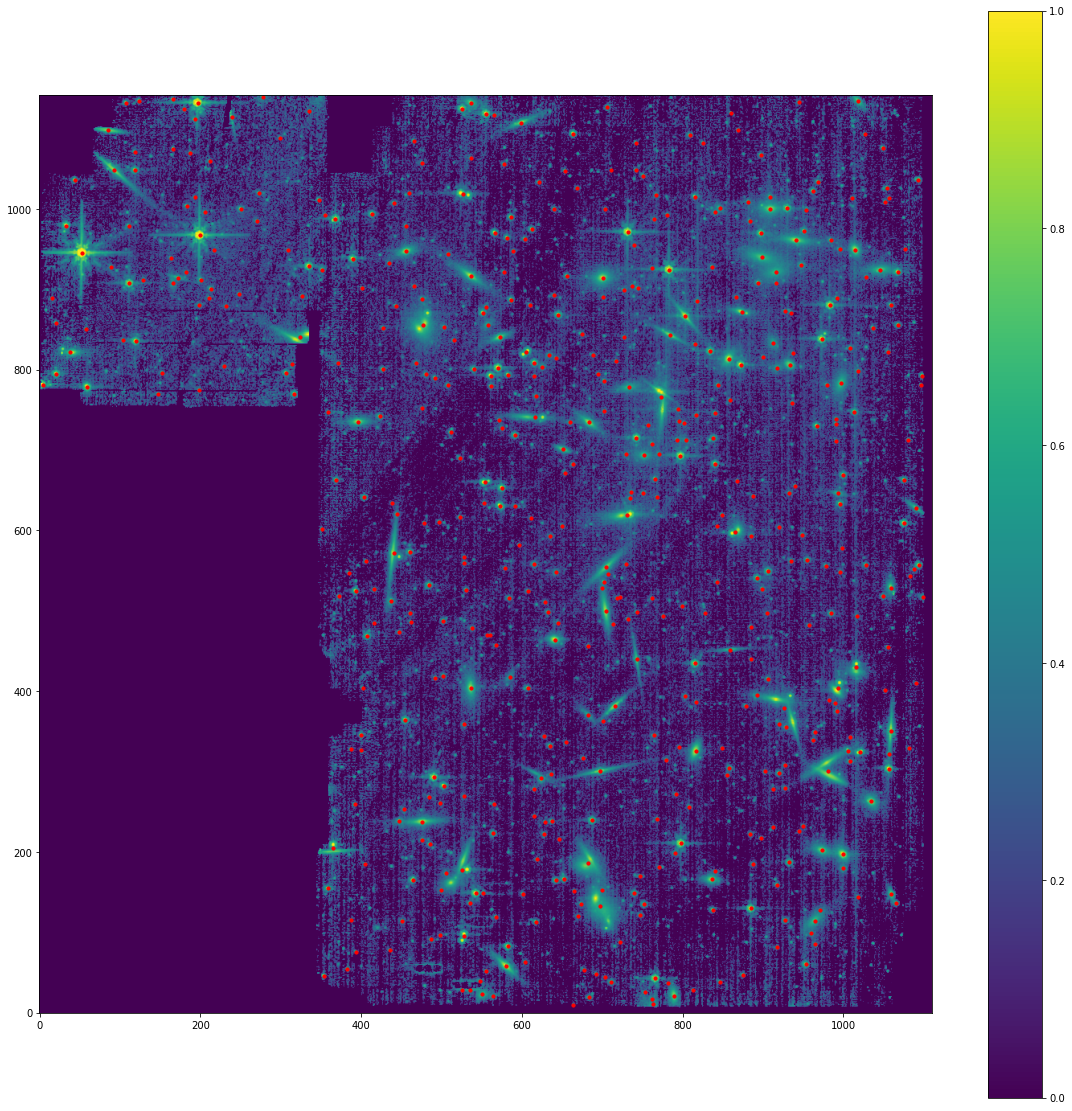

In [16]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table

viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
plt.imshow(viz2(im_i2d.data), origin='lower')
#plt.imshow(im_i2d.data, origin='lower', cmap='rainbow', vmin=0, vmax=0.3)
plt.colorbar()
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')

### In the image above, check that the stars found by source catalog (red) overlap with stars in the image

### Look at the fluxes of the sources found

Text(0, 0.5, 'aper_total_flux')

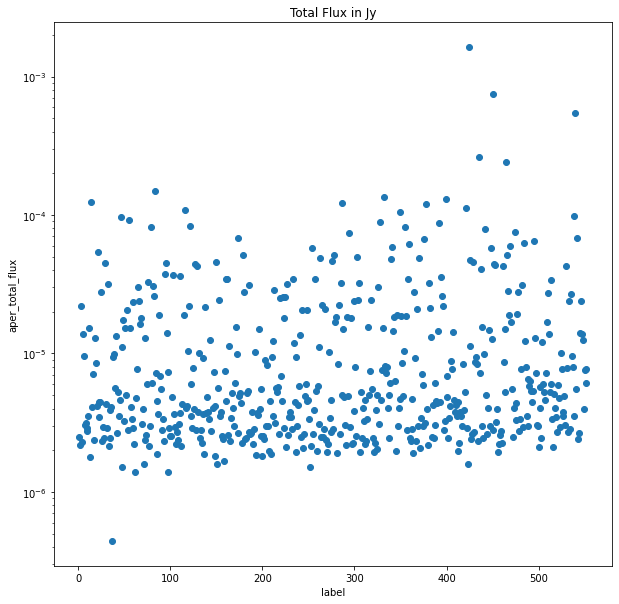

In [17]:
#create_scatterplot(catalog['label'], catalog['aper_total_flux'],title='Total Flux in '+str(catalog['aper_total_flux'].unit))

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

ax.scatter(catalog['label'], catalog['aper_total_flux'])
plt.yscale('log')
plt.title('Total Flux in '+ str(catalog['aper_total_flux'].unit))
plt.xlabel('label')
plt.ylabel('aper_total_flux')

### Look at AB mag of sources found

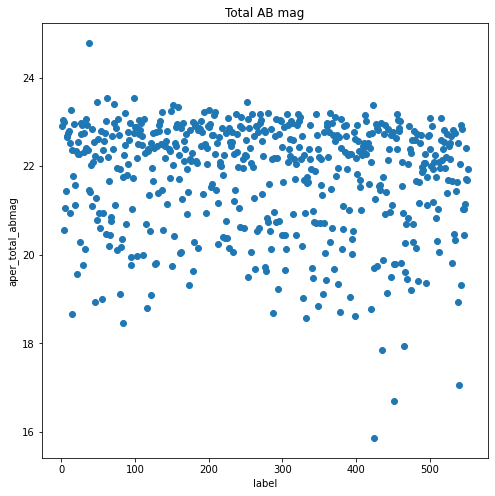

In [18]:
create_scatterplot(catalog['label'], catalog['aper_total_abmag'],title='Total AB mag')

### Look at the errors on the AB magnitudes

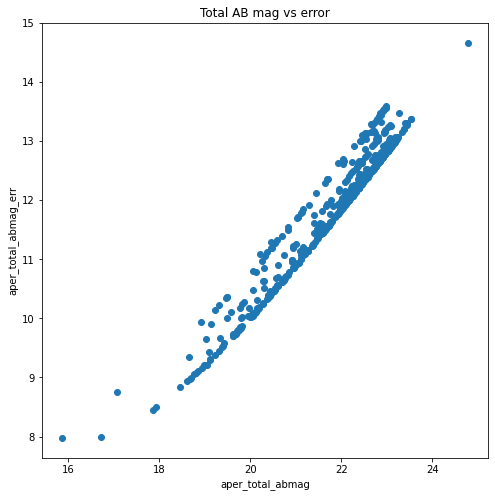

In [19]:
create_scatterplot(catalog['aper_total_abmag'], catalog['aper_total_abmag_err'],title='Total AB mag vs error')

### Manually find matches
Since this is a simulated data set, we can compare the output catalog information from the pipeline with the input catalog information used to create the simulation. Grab the input catalog x,y values and the output catalog x and y values.

In [20]:
# Read in catalogs used for simulated data
sim_star_cat = Table.read('input_sim_stars.cat', format='ascii')
sim_gal_cat = Table.read('input_sim_galaxies.cat', format='ascii')

In [21]:
sim_star_cat


<Table length=4826>
         x                    y          ...         J         
      float64              float64       ...      float64      
-------------------- ------------------- ... ------------------
    80.2510308154624  23.997467884837725 ...  23.18070004336019
 -47.261524228197935  10.919745186379808 ...  23.18070004336019
 0.30699104430734203  -58.51295402429979 ...  23.18070004336019
   93.61585359712294  10.466443553979882 ...  23.18070004336019
   70.96910779066107   63.07387861912006 ...  23.18070004336019
    92.9069476014962   64.30856174275276 ...  23.18070004336019
  -15.68679078862531  31.013432097907607 ...  23.18070004336019
  46.755851500202645  -48.43985094005038 ...  23.18070004336019
    89.7351811921786   53.11182881807044 ...  23.18070004336019
    36.8486881036986  55.211246043351814 ...  23.18070004336019
                 ...                 ... ...                ...
  -53.75703837846754 -15.056996445192539 ...  14.41384375773162
-0.03077487414979152  36.278182742815886 ... 14.401307904146263
   95.63356755906099   44.16471129241473 ...   14.3573115045063
   90.27300634079342  14.709913368541772 ... 14.318203593715223
   66.73346488575024  53.530350294809374 ... 13.714329206276458
    64.8587912432001   35.35455796920176 ... 13.375350808436671
  -53.64831916556537 -32.595812402656435 ... 13.365197793135147
  -46.87584310414583  -39.38515541475271 ... 12.851491317487538
   80.81191419293565  31.516610885465813 ... 12.581530000493744
   96.33858842136043   46.06905445046372 ... 11.872435221133179

In [22]:
# join the star and galaxy catalogs used to make the simulations
combined = table.vstack([sim_star_cat, sim_gal_cat])
combined


<Table length=5039>
         x                   y          ...        flux       
      float64             float64       ...      float64      
------------------- ------------------- ... ------------------
   80.2510308154624  23.997467884837725 ...                 --
-47.261524228197935  10.919745186379808 ...                 --
0.30699104430734203  -58.51295402429979 ...                 --
  93.61585359712294  10.466443553979882 ...                 --
  70.96910779066107   63.07387861912006 ...                 --
   92.9069476014962   64.30856174275276 ...                 --
 -15.68679078862531  31.013432097907607 ...                 --
 46.755851500202645  -48.43985094005038 ...                 --
   89.7351811921786   53.11182881807044 ...                 --
   36.8486881036986  55.211246043351814 ...                 --
                ...                 ... ...                ...
   67.9805698605627  28.494828715119297 ... 13.752965618162937
 -4.446155064406765  12.985674228459532 ...  20.07141274178467
   64.7244492666461  10.113732329735475 ...  66.30990252944302
 -26.44617200253474  -63.88803361596829 ...  85.42806519275359
 12.353908822597736  10.271889771234832 ...  39.37631906390017
 -42.21461912208557   62.45020775429763 ...  131.3721604911842
 -48.68869520916011 -16.576483230280186 ...   59.0685397583837
  86.72084849551925 -30.653820797204745 ...  32.74018847376189
  90.56731424478109 -11.922514577935111 ... 168.84275608114189
   65.4485869690741   60.09508331438365 ... 144.44919876820663

In [23]:
sim_ra = combined['x']/3600.
sim_dec = combined['y']/3600.

### Use MIRI software to put x, y coordinates from input catalog into RA, Dec coordinates

In [24]:
# Put star positions into RA and Dec

# import coordinate conversion tools
#import miricoord.tel.tel_tools as teltools
#import miricoord.imager.mirim_pipetools as mpt
#import miricoord.imager.mirim_tools as mt
#import pysiaf

#filt = 'F560W'
# use pipeline to get v2ref and v3ref coordinates
#siaf = pysiaf.Siaf('MIRI')
#xref,yref=siaf['MIRIM_FULL'].XDetRef,siaf['MIRIM_FULL'].YDetRef
#xref,yref=xref-1,yref-1
#v2ref,v3ref=mt.xytov2v3(xref,yref,filt)

# set reference for RA and Dec
#raref = 0.0
#decref = 0.0
#rollref = 0.0

#sim_ra = np.zeros(len(combined))
#sim_dec = np.zeros(len(combined))

# cycle through list of coordinates input into scene and get RA/Dec values out, printing to file
#for i in range(len(combined)):
    #print(combined['x'][i])
#    v2 = v2ref + combined['x'][i]
#    v3 = v3ref + combined['y'][i]
#    ra,dec,newroll=teltools.jwst_v2v3toradec(v2,v3,v2ref=v2ref,v3ref=v3ref,raref=raref,decref=decref,rollref=rollref)
    
#    sim_ra[i] = ra
#    sim_dec[i] = dec
    
#print(np.shape(sim_ra))
#print(sim_ra, sim_dec)

### Compare RA, Dec coordinates between simulator catalog and output catalog to find matches

In [25]:
cat_ra = catalog['sky_centroid'].ra.deg
for i in range(len(cat_ra)):
    if (cat_ra[i]>180.):
        cat_ra[i] -= 360.
cat_dec = catalog['sky_centroid'].dec.deg

In [26]:
# set the tolerance for differences and initialize counters

tol = 1.e-5    # Set tolerance around 30 mas (units here are in degrees; 36 mas ~ 1e-5 deg)
found_count=0
multiples_count=0
missed_count=0

In [27]:
# Set up array for matches
detected = np.chararray(len(sim_ra))
#print(np.shape(detected))

for ra,dec,idx in zip(sim_ra, sim_dec,range(len(sim_ra))):

    match = np.where((np.abs(ra-cat_ra) < tol) & (np.abs(dec-cat_dec) < tol))
    #print('match', match)
    
    if np.size(match) == 1: 
        found_count +=1 
        detected[idx] = 'Y'

    if np.size(match) > 1:  
        multiples_count +=1       
        
    if np.size(match) < 1:
        missed_count +=1

#print(np.shape(detected))

In [28]:
total_percent_found = (found_count/len(sim_ra))*100

print('\n')
print('SNR threshold used for pipeline: ',pipe3.source_catalog.snr_threshold)
print('Total matches found:',found_count)
print('Total missed:',missed_count)
print('Number of multiples: ',multiples_count)
print('Total number of input (simulated) sources:',len(combined))
print('Total number in output catalog:',len(catalog))
print('Total percent found:',total_percent_found)
print('\n')



SNR threshold used for pipeline:  8
Total matches found: 434
Total missed: 4605
Number of multiples:  0
Total number of input (simulated) sources: 5039
Total number in output catalog: 552
Total percent found: 8.612820003969041




### Use photutils to find catalog matches and compare which sources were found and matched.

Photutils includes a package to match sources between catalogs by providing a max separation value. Set that value and compare the two catalogs.


In [29]:
catalog_in = SkyCoord(ra=sim_ra*u.degree, dec=sim_dec*u.degree) # full simulated catalog, stars+galaxies
catalog_out = SkyCoord(ra=cat_ra*u.degree, dec=cat_dec*u.degree)

In [30]:
max_sep = 0.04 * u.arcsec # Set match at around 30 mas

In [31]:
# match full tables
idx, d2d, d3d = match_coordinates_sky(catalog_in, catalog_out)
sep_constraint = d2d < max_sep
combined_matched = combined[sep_constraint] # simulated sources matched
catalog_matched = catalog[idx[sep_constraint]] # sources found matched

print(catalog_matched.colnames)
print()
print(catalog_matched)

['label', 'xcentroid', 'ycentroid', 'sky_centroid', 'aper_bkg_flux', 'aper_bkg_flux_err', 'aper30_flux', 'aper30_flux_err', 'aper50_flux', 'aper50_flux_err', 'aper70_flux', 'aper70_flux_err', 'aper_total_flux', 'aper_total_flux_err', 'aper30_abmag', 'aper30_abmag_err', 'aper50_abmag', 'aper50_abmag_err', 'aper70_abmag', 'aper70_abmag_err', 'aper_total_abmag', 'aper_total_abmag_err', 'aper30_vegamag', 'aper30_vegamag_err', 'aper50_vegamag', 'aper50_vegamag_err', 'aper70_vegamag', 'aper70_vegamag_err', 'aper_total_vegamag', 'aper_total_vegamag_err', 'CI_50_30', 'CI_70_50', 'CI_70_30', 'is_extended', 'sharpness', 'roundness', 'nn_label', 'nn_dist', 'isophotal_flux', 'isophotal_flux_err', 'isophotal_abmag', 'isophotal_abmag_err', 'isophotal_vegamag', 'isophotal_vegamag_err', 'isophotal_area', 'semimajor_sigma', 'semiminor_sigma', 'ellipticity', 'orientation', 'sky_orientation', 'sky_bbox_ll', 'sky_bbox_ul', 'sky_bbox_lr', 'sky_bbox_ur']

label xcentroid ...                 sky_bbox_ur     

In [32]:
#match RA and Dec
idx, d2d, d3d = match_coordinates_sky(catalog_in, catalog_out)
sep_constraint = d2d < max_sep
catalog_in_matches = catalog_in[sep_constraint]
catalog_out_matches = catalog_out[idx[sep_constraint]]
print(catalog_out_matches)

<SkyCoord (ICRS): (ra, dec) in deg
    [(9.95702148e-04, -7.34674116e-03), (5.69051411e-03, -4.48628659e-03),
     (7.49648944e-04, -2.58082000e-03), (3.59992077e+02, -1.38452742e-02),
     (3.59992465e+02,  2.98859764e-05), (6.40877784e-04,  1.00878668e-02),
     (3.59997291e+02,  4.41754549e-04), (3.59999188e+02,  4.77733294e-03),
     (2.87788595e-03, -1.13957341e-02), (5.58344168e-03, -4.44521995e-03),
     (3.59994260e+02, -6.89382605e-03), (8.89239272e-04, -2.62918602e-03),
     (3.59998007e+02, -8.09516922e-03), (2.26681372e-03, -1.20218888e-02),
     (3.59997244e+02,  5.32192244e-03), (4.01435663e-04, -3.38420663e-03),
     (4.76953666e-03,  5.58791560e-03), (3.59992428e+02, -5.81213997e-03),
     (3.59996679e+02,  2.25700329e-03), (6.45601525e-04, -1.30546779e-03),
     (3.59999695e+02,  1.37771364e-03), (4.01301909e-03,  6.32844647e-03),
     (1.22959421e-02,  5.39585466e-03), (2.00142618e-02,  7.90781449e-03),
     (1.34167544e-03,  9.34409414e-03), (1.39163793e-03,  1.08872

Now, catalog_in_matches and catalog_out_matches are the matched sources in catalog_in and catalog_out, respectively, which are separated less than our max_sep value.

In [33]:
print('Number of matched sources using max separation of '+str(max_sep)+': ',len(catalog_matched))

Number of matched sources using max separation of 0.04 arcsec:  430


### Plot RA and Dec positions of both catalogs
The simulated positions are in red and the sources found with source catalog are marked in blue. Matched sources from both are marked in green.

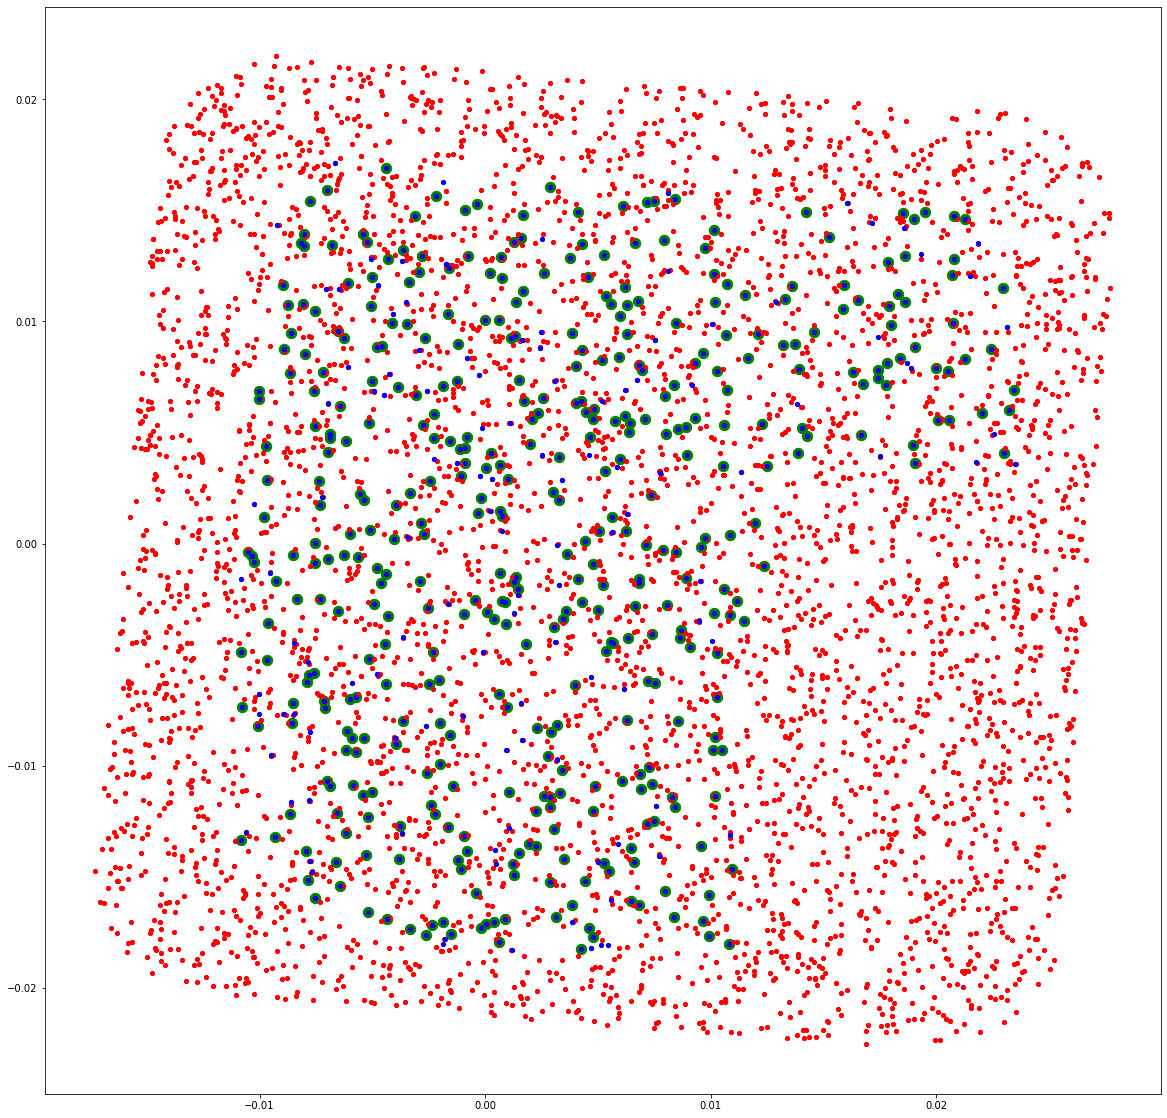

In [34]:
#rrr = catalog_in_matches.ra.deg
#ddd = catalog_in_matches.dec.deg

rrr = catalog_matched['sky_centroid'].ra.deg
ddd = catalog_matched['sky_centroid'].dec.deg

# make sure ra is in proper range for display
plt.figure(figsize=(20,20))
for i in range(len(rrr)):
    if (rrr[i]>180.):
        rrr[i] -= 360.
        
plt.scatter(rrr, ddd, lw=1, s=108,color='green')
plt.scatter(sim_ra, sim_dec,lw=1, s=18,color='red')
plt.scatter(cat_ra, cat_dec,lw=1, s=18,color='blue')

### Convert matched RA/Dec coordinates back to x,y positions and plot matched stars on image

In [35]:
# Convert matched RA/Dec values back to x, y to plot on image

#print(catalog_out_matches)

# Read in wcs values from file header (in extension 1)
#hdu = fits.open(input_file)[1]  
#wcs = WCS(hdu.header)  

# convert positions from RA/Dec back to x,y

#x_matched, y_matched = wcs.world_to_pixel(catalog_out_matches)

#print(x_matched)

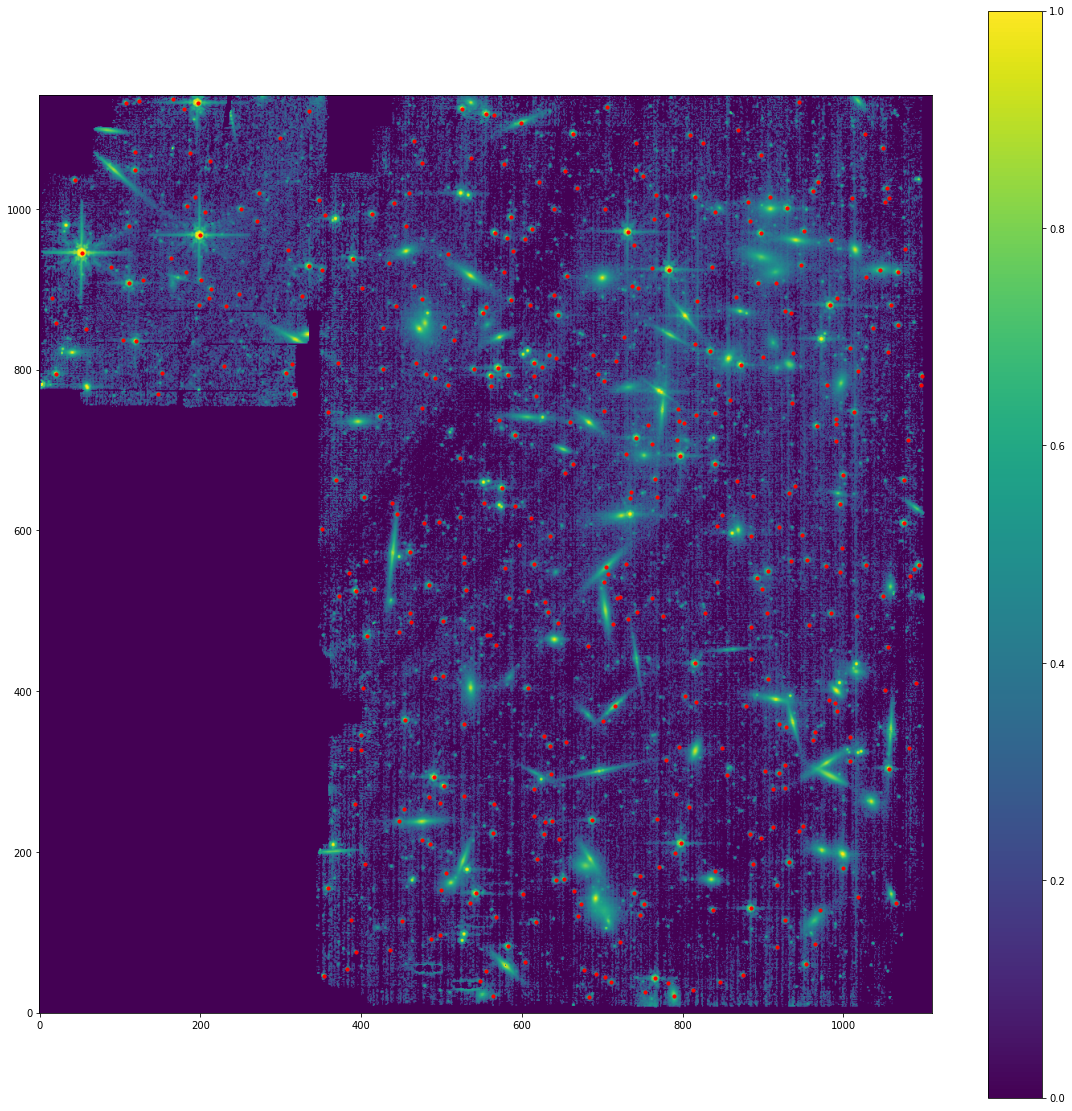

In [36]:
# Plot all matched sources in red

viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
plt.imshow(viz2(im_i2d.data), origin='lower')
#plt.imshow(im_i2d.data, origin='lower', cmap='rainbow', vmin=0, vmax=0.3)
plt.colorbar()
#plt.scatter(x_matched, y_matched,lw=1, s=10,color='red')
plt.scatter(catalog_matched['xcentroid'], catalog_matched['ycentroid'], lw=1, s=10, color='red')      

### Compare to full catalog and see where differences are
The full source_catalog output is shown with red dots and the matched sources are shown with smaller white dots over the red dots. This shows the sources that were found in the catalog (source_catalog step) but not listed as a match between the input and calculated catalogs.

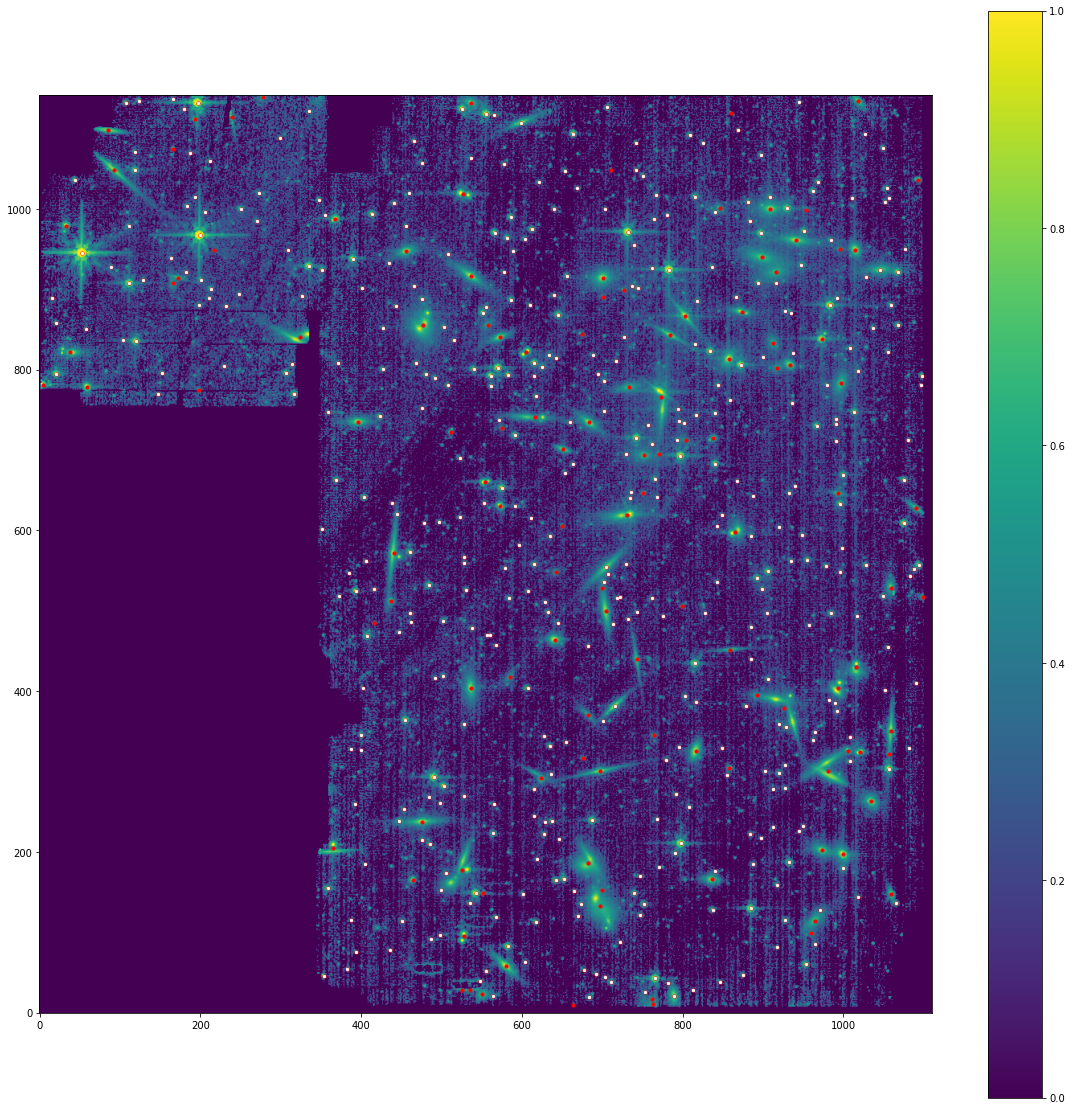

In [37]:
viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
plt.imshow(viz2(im_i2d.data), origin='lower')
#plt.imshow(im_i2d.data, origin='lower', cmap='rainbow', vmin=0, vmax=0.3)
plt.colorbar()
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')
#plt.scatter(x_matched, y_matched,lw=1, s=5,color='white')
plt.scatter(catalog_matched['xcentroid'], catalog_matched['ycentroid'], lw=1, s=5, color='white')

### Look at positions of sources in the simulated images from the catalogs used to create the images

Are there more stars/galaxies in the simulation input catalogs than actually fit on the combined image? That would explain the sources beyond image edges.

In [38]:
print(catalog_in)

<SkyCoord (ICRS): (ra, dec) in deg
    [(2.22919530e-02,  0.00666596), (3.59986872e+02,  0.00303326),
     (8.52752901e-05, -0.0162536 ), ..., (2.40891246e-02, -0.00851495),
     (2.51575873e-02, -0.00331181), (1.81801630e-02,  0.01669308)]>


In [39]:
# Read in wcs values from file header (in extension 1)
hdu = fits.open(input_file)[1]  
wcs = WCS(hdu.header)  

# convert positions from RA/Dec back to x,y

x_sim, y_sim = wcs.world_to_pixel(catalog_in)

# Many sources go beyond image edges. Only display sources that were actually in FOV of combined image.
minval = 0
maxval = 1140

ind = np.where((x_sim > minval) & (x_sim < 1110)& (y_sim > minval) & (y_sim < maxval))


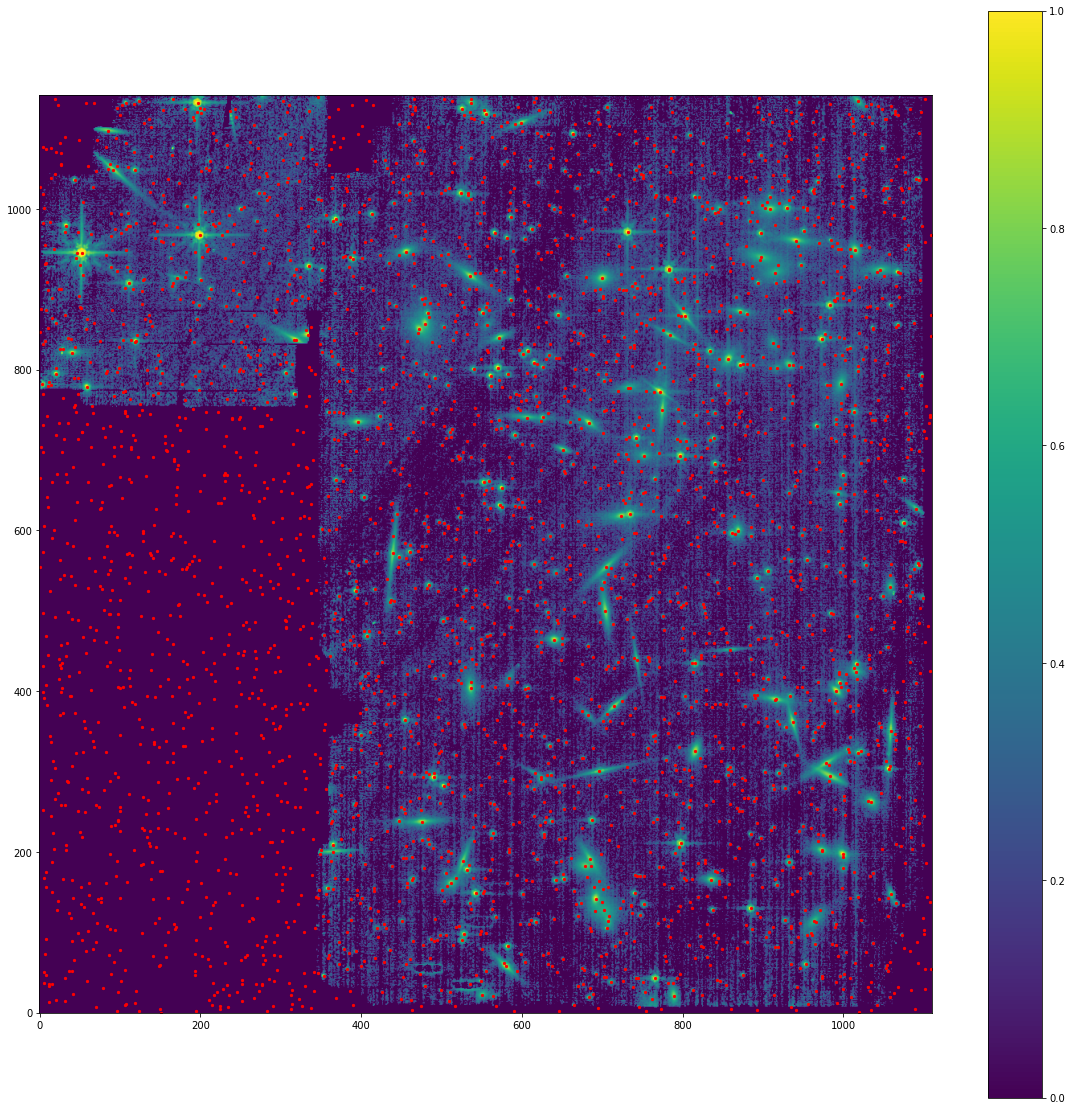

In [40]:
viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
plt.imshow(viz2(im_i2d.data), origin='lower')
#plt.imshow(im_i2d.data, origin='lower', cmap='rainbow', vmin=0, vmax=0.3)
plt.colorbar()
plt.scatter(x_sim[ind], y_sim[ind],lw=1, s=5,color='red')

## Compare fluxes between input sources and output catalog

Input catalog 'combined' has Ks and J columns for stars and flux for galaxies.
Output source catalog 'catalog' has aper_total_flux, 'isophotal_flux', 'aper_total_abmag', 'aper_total_vegamag', 'isophotal_abmag' and isophotal_vegamag.

The first plot compares the magnitudes for the input simulated catalog (in blue) and the sources found with source catalog in green.

### Compare the star magnitudes and magnitude differences to the x position of the stars.


In [41]:
flux, wref = mag2flux(combined_matched['Ks'], band="Ks", system="2MASS")
fnew = extrapolate_flux(flux, wref, 7.7, combined_matched['Teff'])
F770W_ABmag = -2.5*np.log10((fnew.to(u.Jy)).value) + 8.9

2022-01-28 12:56:56,372 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



2022-01-28 12:56:56,386 - stpipe - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope@2/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)



Magnitude         Ks        
------------------
 19.88386593994985
19.859295642920145
19.828355268882742
19.827445257881642
 19.82380521387724
19.782854718827735
 19.75828442179803
 19.74554426778263
 19.73007408076393
19.710053838739725
               ...
13.952102383594207
13.881869560311879
13.126635236879519
12.776853158671695
 11.94688436179194
                --
                --
                --
                --
                --
                --
Length = 430 rows in 2MASS band Ks -> Flux: [7.41966127e-06 7.58948310e-06 7.80887278e-06 7.81542054e-06
 7.84166653e-06 8.14307749e-06 8.32945692e-06 8.42777142e-06
 8.54871469e-06 8.70780950e-06 8.72241867e-06 8.82537138e-06
 8.94452043e-06 9.10334816e-06 9.21079708e-06 9.22625010e-06
 9.24172906e-06 9.27276492e-06 9.31170635e-06 9.33514966e-06
 9.33514966e-06 9.46911432e-06 9.59695437e-06 9.62111583e-06
 9.71837149e-06 9.71837149e-06 9.73467608e-06 9.75918427e-06
 9.79195786e-06 9.85783560e-06 9.89094048e-06 9.97418990e-06
 1

### Plot AB mag vs x position
Simulated stars in blue, sources found in green.

Text(0, 0.5, 'AB mag')

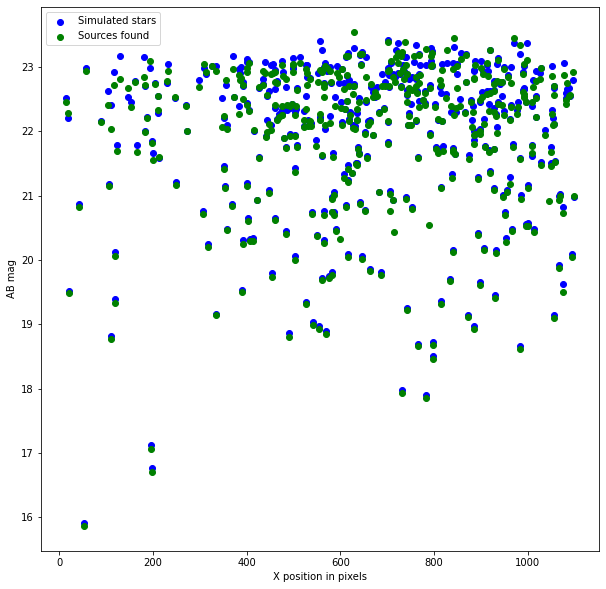

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

ax.scatter(catalog_matched['xcentroid'], F770W_ABmag, color='blue', label='Simulated stars')
ax.scatter(catalog_matched['xcentroid'], catalog_matched['aper_total_abmag'], color='green', label='Sources found')
ax.legend()

plt.xlabel('X position in pixels')
plt.ylabel('AB mag')

### Plot difference in magnitude against x and y position.
Found catalog minus matched simulated AB mag vs. x position and vs. y position, with the median magnitude difference plotted as a horizontal line in red.

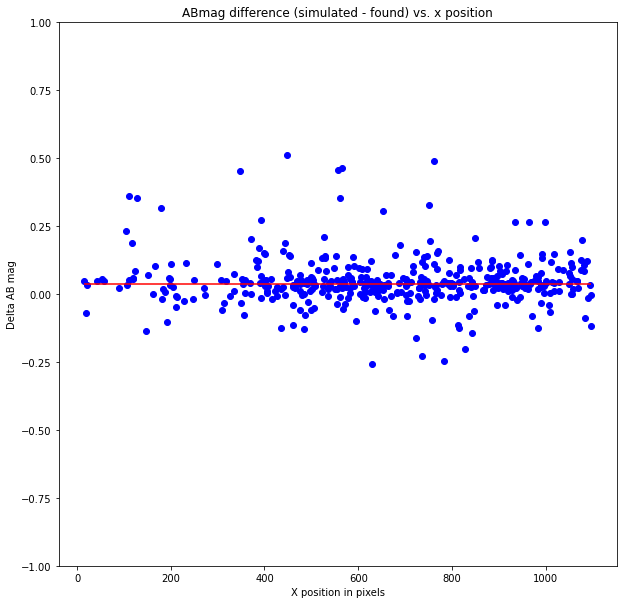

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

ax.set_ylim(-1,1)
ax.scatter(catalog_matched['xcentroid'], F770W_ABmag-catalog_matched['aper_total_abmag'], color='blue')

#ax.legend()
plt.title('ABmag difference (simulated - found) vs. x position')
plt.xlabel('X position in pixels')
plt.ylabel('Delta AB mag')

ok = np.logical_and(F770W_ABmag>0, F770W_ABmag<100)

m = F770W_ABmag[ok]-catalog_matched['aper_total_abmag'][ok]
np.median(m)
plt.hlines(np.median(m), min(catalog_matched['xcentroid']), max(catalog_matched['xcentroid']), color='red')

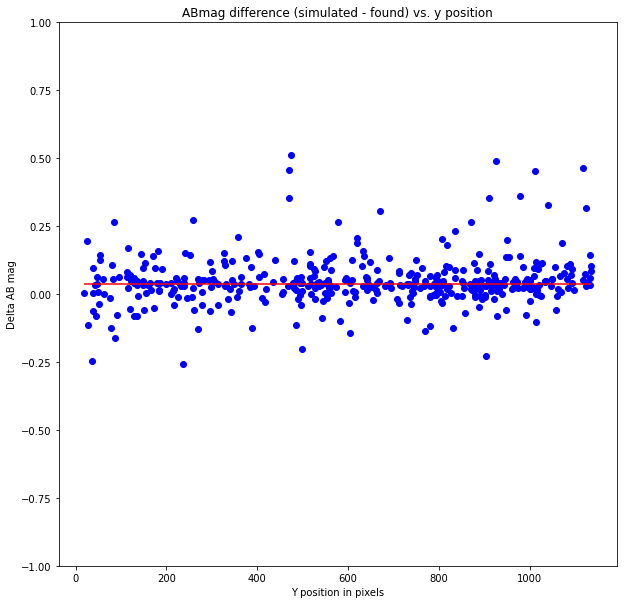

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

ax.set_ylim(-1,1)
ax.scatter(catalog_matched['ycentroid'], F770W_ABmag-catalog_matched['aper_total_abmag'], color='blue')
#ax.legend()

plt.title('ABmag difference (simulated - found) vs. y position')
plt.xlabel('Y position in pixels')
plt.ylabel('Delta AB mag')

ok = np.logical_and(F770W_ABmag>0, F770W_ABmag<100)

m = F770W_ABmag[ok]-catalog_matched['aper_total_abmag'][ok]
np.median(m)
plt.hlines(np.median(m), min(catalog_matched['ycentroid']), max(catalog_matched['ycentroid']), color='red')

### Plot AB magnitude difference against AB mag to see if there is a pattern in the differences by mag.

Median difference marked by line in red.

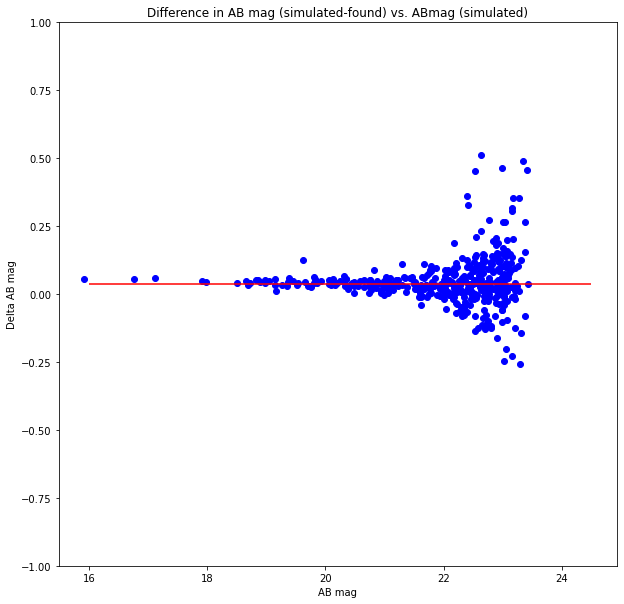

In [45]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()

ax.set_ylim(-1,1)
ax.scatter(F770W_ABmag, F770W_ABmag-catalog_matched['aper_total_abmag'], color='blue')
#ax.legend()

plt.title('Difference in AB mag (simulated-found) vs. ABmag (simulated)')
plt.xlabel('AB mag')
plt.ylabel('Delta AB mag')

ok = np.logical_and(F770W_ABmag>0, F770W_ABmag<100)

m = F770W_ABmag[ok]-catalog_matched['aper_total_abmag'][ok]
np.median(m)
plt.hlines(np.median(m), 16, 24.5, color='red')

#### Passing criteria

Look at the matched image to see what sources were matched between the simulated and found catalogs and see if there is a pattern to which 'found' sources were not matched to the simulated catalog. Are they mostly galaxies or were the found sources in areas of confusion between two stars or sources where the source finding algorithm might not have pinpointed the actual centroid of the source. If the majority of the sources matched seem to be the stars that are clearly marked and properly found, that part of the test passes.

If the plots showing magnitudes of the matched sources show that they're close (exact criteria for 'close' TBD), then that test passes.

This test is mostly visual inspection of the images and plots. As long as nothing is obviously wrong (no columns in the table marked as all NaNs, sources found seem to be real sources, and a good number of them match the simulated sources input into the image), then this test passes.

#### About this Notebook

Authors: M. Cracraft, M. Libralato and T. Temim, MIRI Branch

Updated On: 08/18/2021
